## init

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from IPython.display import Image

In [154]:
data_dir = 'C:/users/juwon/practice_aiffel/kaggle-kakr-housing-data/data/'

train_data_path = data_dir + 'train.csv'
test_data_path = data_dir + 'test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## processing

In [156]:
train['date'] = train['date'].apply(lambda x: x[:6]).astype(int)

y = train['price']

del train['price']
del train['id']

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [157]:
test['date'] = test['date'].apply(lambda x: x[:6]).astype(int)
del test['id']
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## fit features

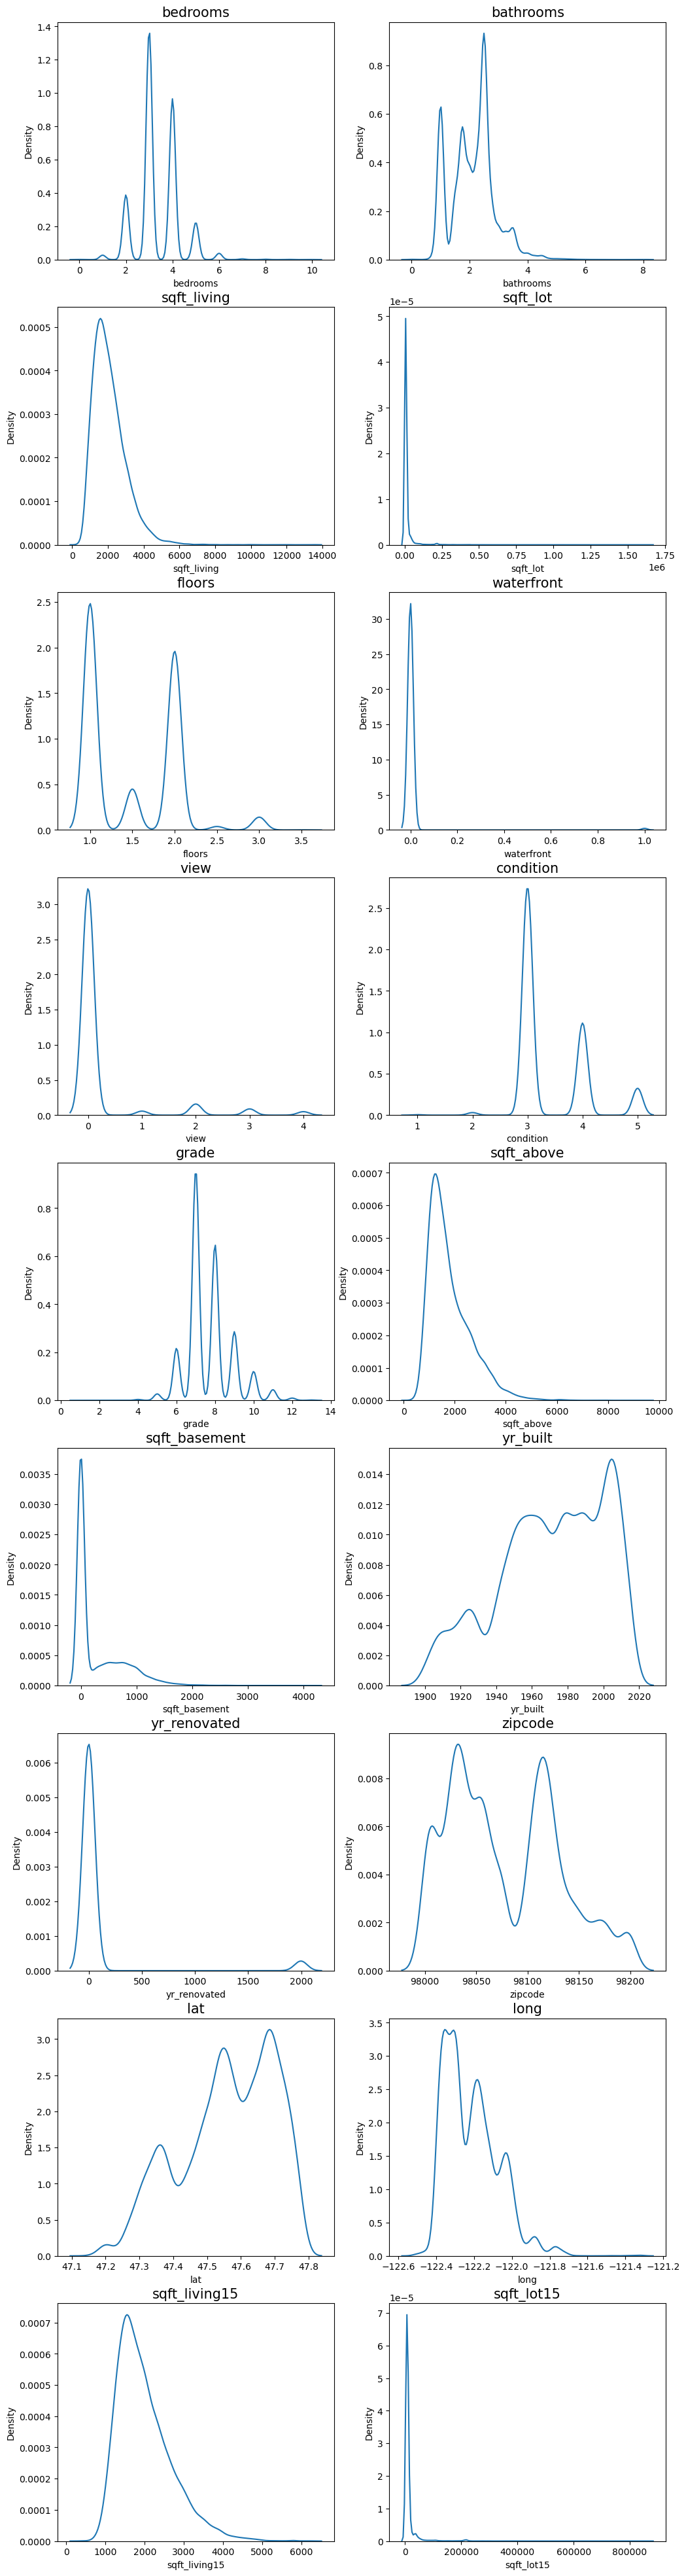

In [158]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [159]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

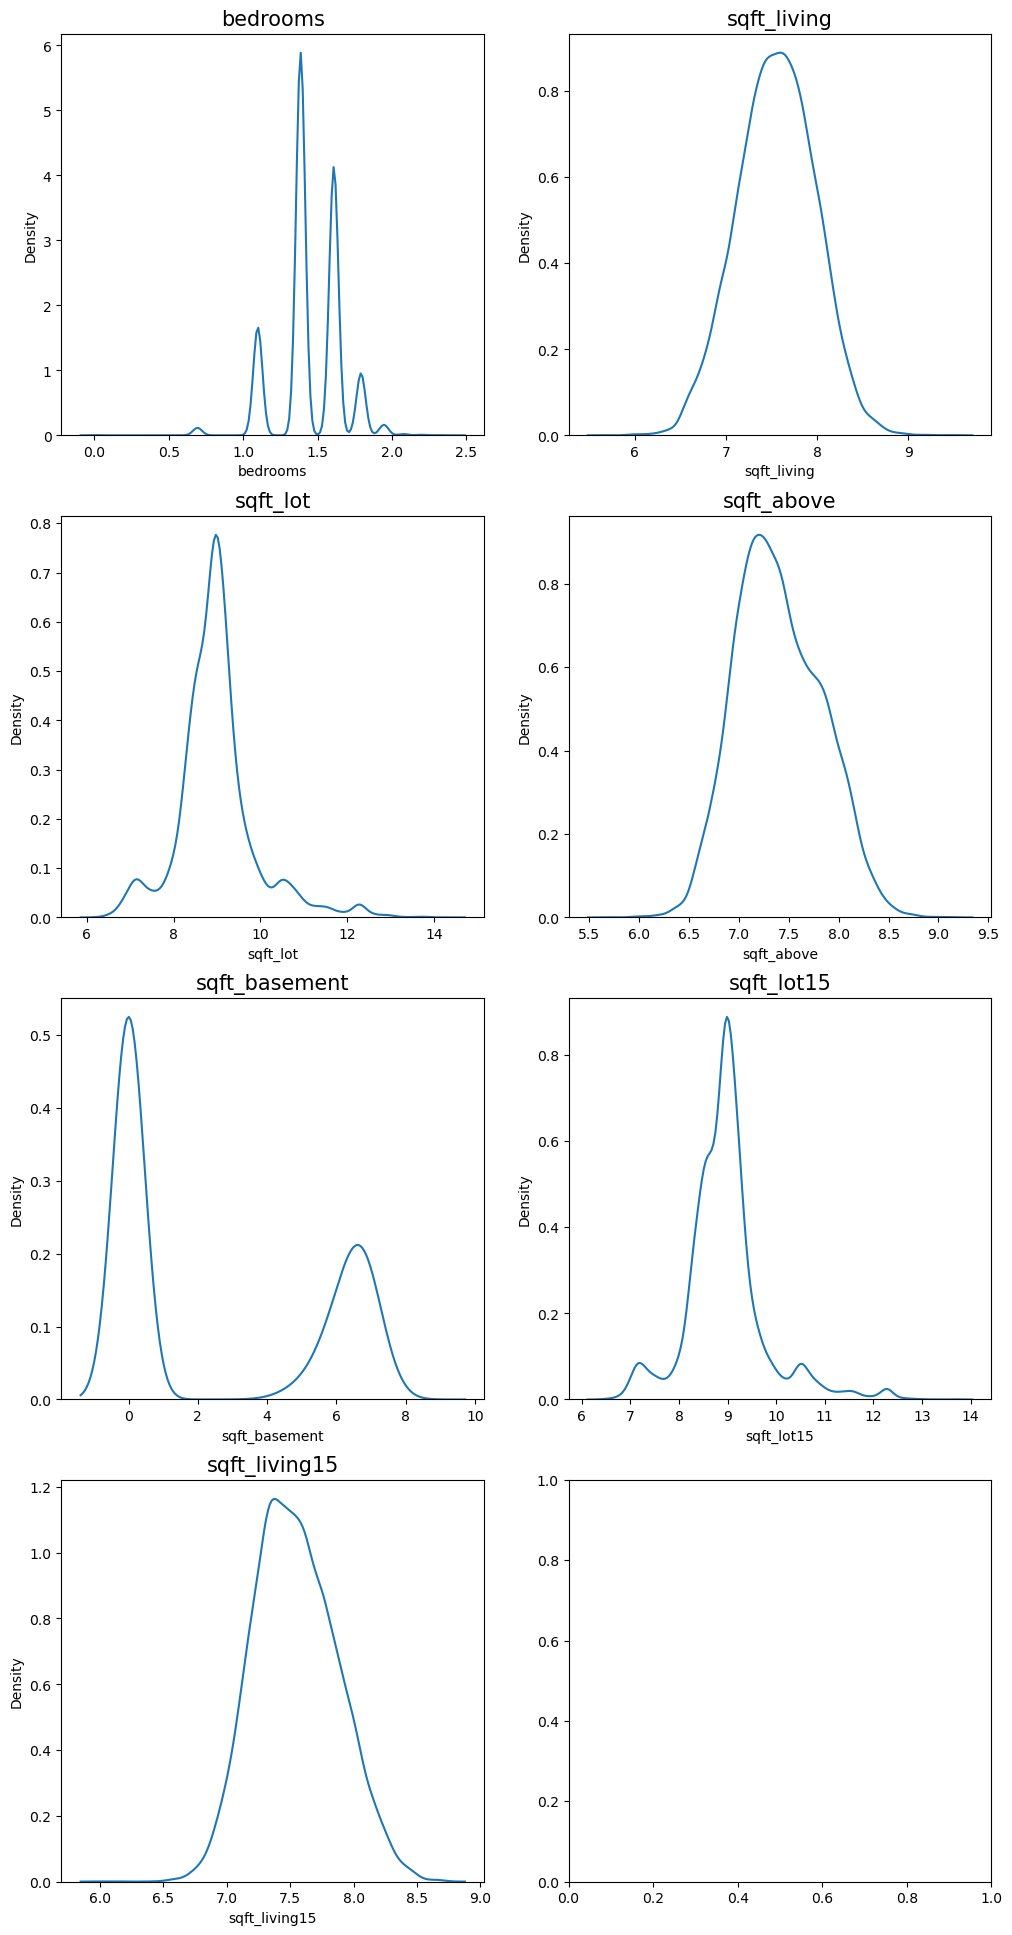

In [160]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [161]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    test[c] = np.log1p(test[c].values)

<function matplotlib.pyplot.show(close=None, block=None)>

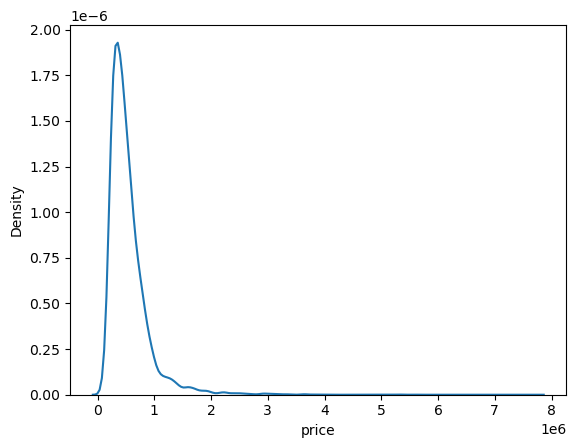

In [162]:
sns.kdeplot(y)
plt.show

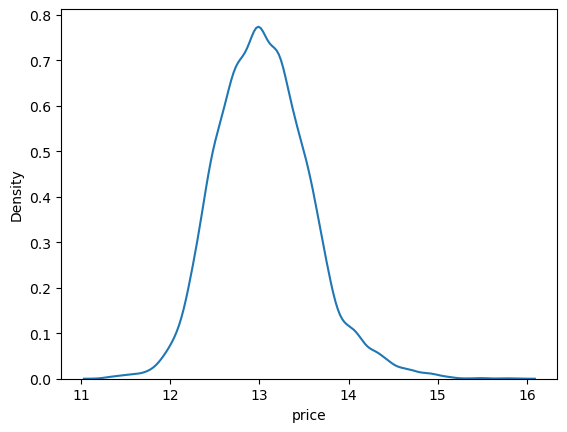

In [163]:
y =np.log1p(y)
sns.kdeplot(y)
plt.show()

In [164]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred)))

In [165]:
random_state=42

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [166]:
def get_scores(models, train, y):
    df = {}
    
    for m in models:
        m_name = m.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        m.fit(X_train, y_train)

        y_pred = m.predict(X_test)

        df[m_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE')
    return score_df

        
get_scores(models, train, y)

,RMSE
LGBMRegressor,123074.604066
XGBRegressor,126741.713801
GradientBoostingRegressor,134139.377568
RandomForestRegressor,141436.286746


## GridSearch

In [167]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5) :
    grid_model = GridSearchCV(model, param_grid= param_grid, scoring = 'neg_mean_squared_error', cv=5,verbose=2,n_jobs=5)

    grid_model.fit(train,y)

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

In [175]:
param_grid = {
    'n_estimators': [500,1000],
    'max_depth': [-1,10],
    'learning_rate' :[0.075,0.05],
    
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
6,0.050,10,500,-0.025928,0.161021
7,0.050,10,1000,-0.025930,0.161027
5,0.050,-1,1000,-0.026049,0.161396
4,0.050,-1,500,-0.026056,0.161418
0,0.075,-1,500,-0.026068,0.161456
2,0.075,10,500,-0.026071,0.161466
1,0.075,-1,1000,-0.026276,0.162098
3,0.075,10,1000,-0.026461,0.162669


## test

In [174]:
model = LGBMRegressor(max_depth=10, n_estimators=500,learning_rate=0.05,random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)

prediction = np.expm1(prediction)
prediction

array([ 488846.71116279,  488421.24004629, 1336854.4667335 , ...,
        485803.12982415,  318092.59497375,  434804.90225534])

## save

In [117]:
submission_path = data_dir + 'sample_submission.csv'
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.984124e+05
1,15036,4.748022e+05
2,15037,1.369481e+06
3,15038,3.016508e+05
4,15039,3.241803e+05


In [119]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161021')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

C:/users/juwon/practice_aiffel/kaggle-kakr-housing-data/data//submission_lgbm_RMSLE_0.160910.csv


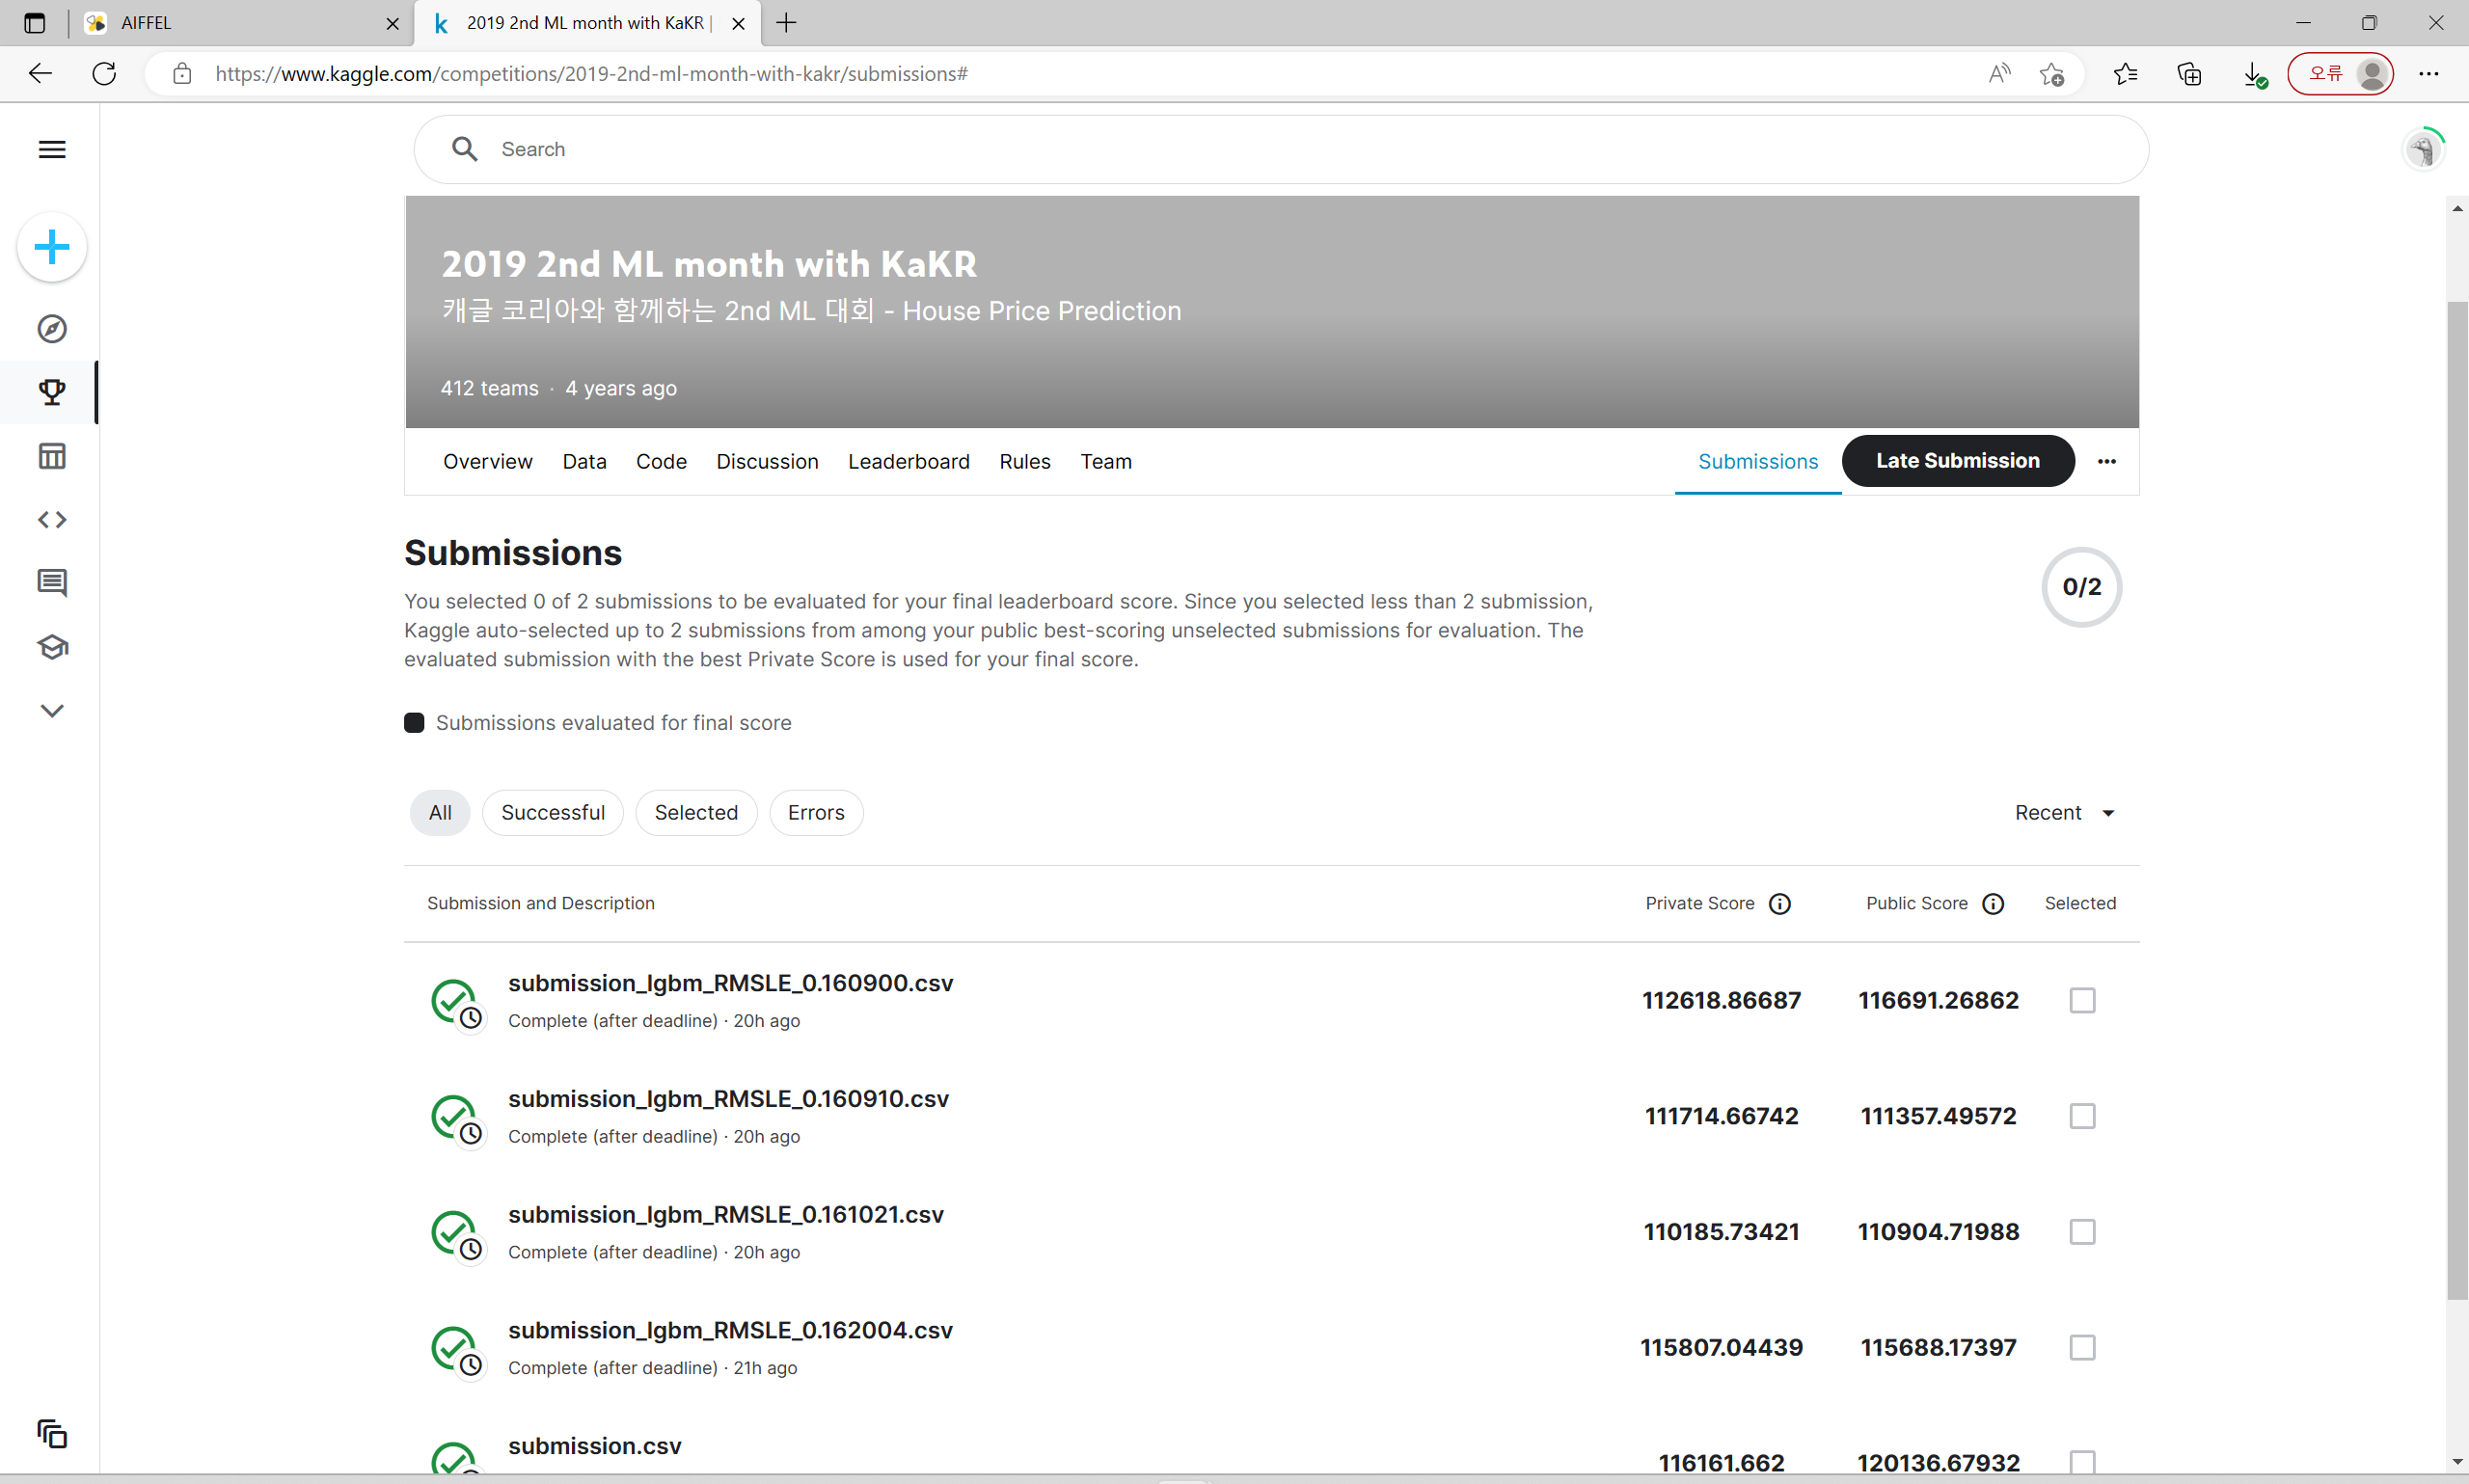

In [4]:
Image("C:/Users/juwon/practice_aiffel/kaggle-kakr-housing-data/data/Ex03_submission.png")